# API REST de 4chan - JSON 
https://github.com/4chan/4chan-API

## Obtener una muestra de dos boards de 4chan, sacando una instantánea concreta (todas las páginas de cada board).

Obtener solo la información para proceder en los dos puntos siguientes: 
- contraste de diferencia de medias en la media de respuestas por posts en cada board 
- obtención la distribución del tamaño de las imágenes.

Procedimiento:
- importar librerías
- selección de dos boards y descripción del JSON
- construcción del dataframe: 
- realización de cálculos:  
    i) contraste de diferencia de medias de respuestas por posts en cada board
    ii) obtención de la distribución del tamaño de las imágenes

In [4]:
import requests as rq 
import json
import pandas as pd
from scipy import stats 

## Comprender el json

Where are the files?

Boards: http(s)://boards.4chan.org/board/

Indexes: http(s)://boards.4chan.org/board/[2-10] (# of pages varies per board, omit number for directory root)

Threads: http(s)://boards.4chan.org/board/thread/resto

Replies: http(s)://boards.4chan.org/board/thread/resto#pno

Images: http(s)://i.4cdn.org/board/tim.ext

El json que devuelve la api: https://github.com/4chan/4chan-API contiene una clave 'boards' que es una lista de diccionarios. Cada uno de estos diccionarios corresponde a una board; tiene conjuntos de clave:valor, entre los que están el "identificador" del 'board:', el número de páginas del board 'pages':  ,entre otros.

{"boards":[{"board":"3","title":"3DCG","ws_board":1,"per_page":15,"pages":10,"max_filesize":4194304,"max_webm_filesize":3145728,"max_comment_chars":2000,"max_webm_duration":120,"bump_limit":310,"image_limit":150,"cooldowns":{"threads":600,"replies":60,"images":60} .....

El json que devuelven los boards que seleccionaré (o cualquier otro board) para el análisis -'Cute/Male' y 'Handsome Male' (http://a.4cdn.org/cm/1.json y http://a.4cdn.org/hm/1.json)- son diccionarios. 
Hay una única clave ‘threads’ que es una lista de diccionarios. Estos diccionarios tienen una clave 'posts' que es una lista de diccionarios:
En este nivel, hay claves:valor que recogen el número del post 'no:', el número de respuestas‘replies:’ y el tamaño de las imágenes ‘fsize:’. 

{"threads"
:[{"posts":[{"no":3035586,"now":"06\/13\/16(Mon)21:43:39","name":"Anonymous","sub":"Harry Potter","com":"<span class=\"quote\">&gt;wolfstar is still not canon<\/span><br><span class=\"quote\">&gt;Voldemort having an emo daughter with scene kid hair is<\/span>","filename":"image","ext":".jpg","w":567,"h":622,"tn_w":227,"tn_h":250,"tim":1465868619589,"time":1465868619,"md5":"N+H9bgvuMyKWS2g2OJZobw==","fsize":106118,"resto":0,"bumplimit":0,"imagelimit":0,"semantic_url":"harry-potter","replies":125,"images":113,"omitted_posts":120,"omitted_images":110}

Estos tres valores son los que se irán incoporando como filas al data frame: el número de post para indexar, y replies y fsize como columnas sobre las que se realizarán los cálculos solicitados.

In [5]:
# De abajo a arriba para la construcción del dataframe: 
# Primero el diseño a partir del post, con selección del elemento que indexa 'no', junto a 'las variables a incorporar: 'fsize' y 'replies'
def adding_row(df, post): 
    fsize = post["fsize"] # Atributo adicional (only displays when image uploaded)
    replies = post["replies"] # Atributo adicional(only displays on OPs -OriginalPoster-)
    df.loc[post["no"]] = [fsize, replies] #Atributo del post object (number of post), utilizado como índice 

In [6]:
# Segundo paso: Selección de la información que se incorpora a las filas del dataframe: 
# posts in threads per page, con información sobre 'fsize' y 'replies' 
def adding_posts(df,page):
    counter = 0
    for thread in page['threads']:
            for post in thread['posts']:
                if ('fsize' in post) and ('replies' in post): # fsize y replies son atributos adicionales
                    adding_row(df,post)
                    counter  += 1
    print("Added posts "+ str(counter)) # Posts añadidos por página

In [7]:
# Tercer paso: Construcción del dataframe
def constructing_dataframe(board_name):
    
    # Descargar los json de los board seleccionados
    req_threads = rq.get('http://a.4cdn.org/'+board_name+'/threads.json')
    # Parsear los json 
    board = json.loads(req_threads.text)
    # Imprimir el número de páginas de los board seleccionados
    print("Pages "+ str(len(board))) 
    
    post_df = pd.DataFrame(columns=["fsize", "replies"])    
    
    for num in range(1,len(board)):
        print("Page " + str(num))
        # Descargar los json de cada una de las páginas de los board seleccionados
        req_page = rq.get('http://a.4cdn.org/'+board_name+'/'+str(num)+'.json')
        # Parsear los json
        page = json.loads(req_page.text)
        adding_posts(post_df,page)    
    return post_df

In [8]:
print('Cute/Male') #Ya puestos, vamos a por Cute/Male, y esperemos que no salga ni D. Trump ni C. Montoro
df_cm = constructing_dataframe('cm')
print(df_cm.head(10))
print('Handsome Men')
df_hm = constructing_dataframe('hm')   
print(df_hm.head(10))

Cute/Male
Pages 10
Page 1
Added posts 15
Page 2
Added posts 15
Page 3
Added posts 15
Page 4
Added posts 15
Page 5
Added posts 15
Page 6
Added posts 15
Page 7
Added posts 15
Page 8
Added posts 15
Page 9
Added posts 15
             fsize  replies
3059967   868248.0     43.0
3059140   104430.0    164.0
3038581   383641.0    112.0
3055675    79754.0     43.0
3039842  1452754.0    164.0
3059948    41348.0     75.0
3050840   316917.0     75.0
3050989   178969.0     57.0
3053745   372666.0    119.0
3052022    17973.0     33.0
Handsome Men
Pages 10
Page 1
Added posts 14
Page 2
Added posts 15
Page 3
Added posts 15
Page 4
Added posts 15
Page 5
Added posts 15
Page 6
Added posts 15
Page 7
Added posts 15
Page 8
Added posts 15
Page 9
Added posts 15
             fsize  replies
1451936   269251.0     14.0
1450101  1823780.0     63.0
1442555    83402.0    160.0
1451706    17229.0     60.0
1380076   474945.0    212.0
1436152   235804.0    172.0
1450959  1405577.0     20.0
1448483  1328001.0    133.0
145

In [9]:
df_cm.shape

(135, 2)

In [10]:
df_hm.shape

(134, 2)

## Contrastar diferencias en la media de respuestas por post en los dos boards elegidos: Cute/Male y Handsome Male.

### Se procederá a realizar un análisis gráfico, mediante boxplot, y a continuación un contraste de medias (paramétrico o no paramétrico según proceda).
### ¿Existe una diferecia en la media de respuestas de las muestras de Cute/Male y Handsome Male? 

([<matplotlib.axis.XTick at 0x11926c350>,
 <a list of 2 Text xticklabel objects>)

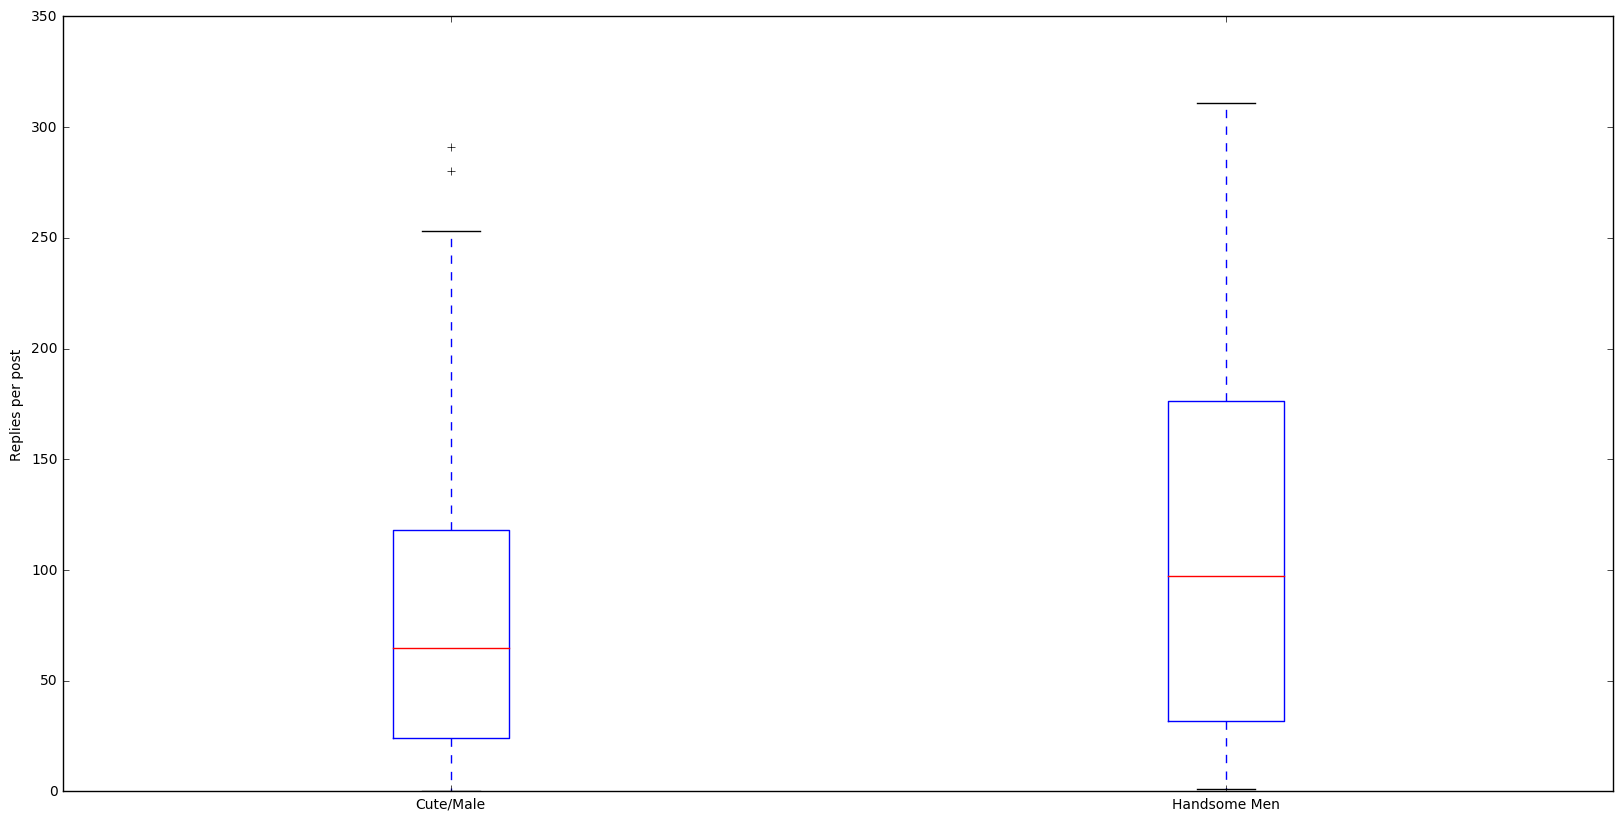

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(1, figsize=(20, 10))

ax = fig.add_subplot(111)

ax.set_ylabel('Replies per post')


bp = ax.boxplot([df_cm.replies.tolist(), df_hm.replies.tolist()])
plt.xticks([1, 2], ['Cute/Male', 'Handsome Men'])

#### Del análisis gráfico se aprecia que el boxplot de la muestra de 'replies' de Cute/male está prácticamente contenido en el de Handsome Men (lógico porque los cutes, incluso en escala de replies, deberían ser una parte de los handsome ;D ). En los dos casos son distribuciones right-skewed; Cute/Male exhibe mayor concentración de observaciones.
#### Se  va a proceder a realizar un contraste de igualdad de medias. En primer lugar, se testeará la normalidad. 

In [12]:
from scipy.stats.mstats import normaltest  
_, pval1 = normaltest(df_cm["replies"])
print pval1

3.3182328227e-05


In [13]:
from scipy.stats.mstats import normaltest  
_, pval1 = normaltest(df_hm["replies"])
print pval1

0.000331152821026


#### Los valores de los p-values descartan la normalidad de las distribuciones. Por ello, se optará para el contraste de igualdad de medias, por un contraste no paramétrico. Se utilizará el test de Mann-Whitney, que no exige el mismo número de observaciones, aunque sí independencia.

In [14]:
stats.mannwhitneyu(x=df_hm.replies, y=df_cm.replies, use_continuity=True, alternative=None)

MannwhitneyuResult(statistic=7505.5, pvalue=0.0079242924029868725)

#### Dado el valor de p-value obtenido se rechaza la hipótesis nula (H0). Ho: las diferencias observadas entre las medias de replies de las dos muestras  se deben al azar. 

## Distribución del tamaño de las imágenes en los posts de uno de los boards.

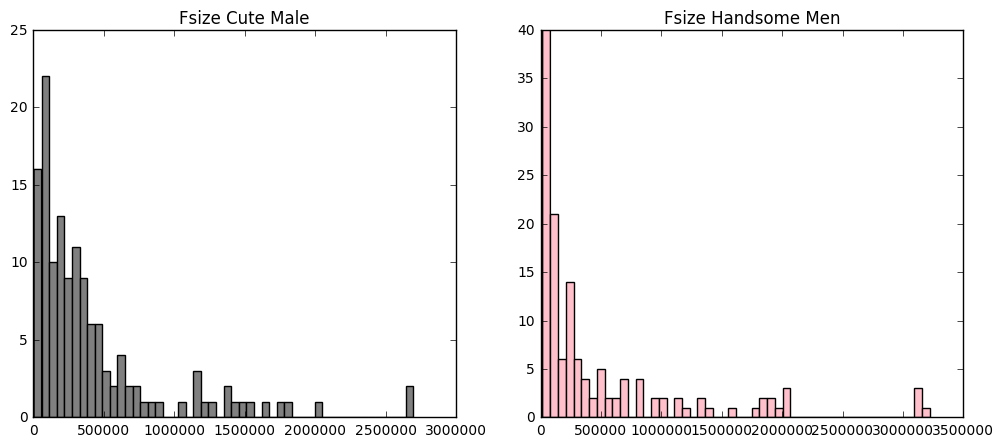

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize=(12,5))
plt.subplot(121)
plt.hist(df_cm.fsize.tolist(), bins=50, color='grey', label='Cute/Male')
plt.title("Fsize Cute Male")


plt.subplot(122)
plt.hist(df_hm.fsize.tolist(), bins=50, color='pink', label='Handsome Men') # Rosa para los handsome
plt.title("Fsize Handsome Men")

### Test de normalidad de las distribuciones

In [18]:
from scipy.stats.mstats import normaltest  
_, pval1 = normaltest(df_cm["fsize"])
print pval1

7.48089715654e-18


In [19]:
from scipy.stats.mstats import normaltest  
_, pval1 = normaltest(df_hm["fsize"])
print pval1

2.35588825623e-16


Se rechaza la normalidad en los dos casos.